In [41]:
import os

import torch
os.environ["TORCH_VERSION"] = torch.__version__

In [42]:
%%bash

pip install torch-scatter torch-sparse torch-geometric -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html


# Implemeting a GNN using PyTorch Geometric

Following along with Chapter 18 of Machine Learning with PyTorch and Scikit-Learn, we will implement a GNN using the PyTorch Geometric library. We will apply a GNN to the QM9 dataset of small molecules to predict isotropic polarizability which is a measure of a molecule’s tendency to have its charge distorted by an electric field.

In [43]:
import matplotlib.pyplot as plt

from torch import nn, utils
from torch.nn import functional as F
from torch_geometric import datasets, loader
from torch_geometric import nn as gnn

In [44]:
datasets.QM9?

In [45]:
qm9_dataset = datasets.QM9("./sample_data")

In [46]:
sample = qm9_dataset[0]

In [47]:
sample.z

tensor([6, 1, 1, 1, 1])

In [48]:
sample["z"]

tensor([6, 1, 1, 1, 1])

In [49]:
sample["some attribute"] = torch.tensor([1.3, 2.0, 4.5])

In [50]:
sample

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], some attribute=[3])

In [51]:
gnn.NNConv?

In [53]:
class GNNRegressor(nn.Module):

    def __init__(self, num_node_features, num_edge_features): 
        super().__init__()

        nn_1 = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features * 32)
        )
        nn_2 = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32 * 16)
        )
        self.nnconv_1 = gnn.NNConv(num_node_features, 32, nn_1)
        self.nnconv_2 = gnn.NNConv(32, 16, nn_2)
        self.linear_1 = nn.Linear(16, 32)
        self.linear_2 = nn.Linear(32, 1)

    def forward(self, data):
        h = F.relu(self.nnconv_1(data.x, data.edge_index, data.edge_attr))
        h = F.relu(self.nnconv_2(h, data.edge_index, data.edge_attr))
        h = gnn.global_add_pool(h, data.batch)
        h = F.relu(self.linear_1(h))
        h = self.linear_2(h)
        return h



## Create train, val, test splits

In [54]:
train_dataset, val_dataset, test_dataset = utils.data.random_split(
    qm9_dataset,
    [110000, 10831, 10000]
)
train_dataloader = loader.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)
val_dataloader = loader.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)
test_dataloader = loader.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

## Train and validate the model

In [57]:
# initialize a network
model = GNNRegressor(11, 4)

# initialize an optimizer with some reasonable parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [58]:
epochs = 5
target_idx = 1

for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    
    model.train()
    for batch in train_dataloader:
        # forward pass
        y_hat = model(batch)
        
        # backward pass
        y = batch.y[:, target_idx].unsqueeze(1)
        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # update batch statistics
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
    
    # update epoch statistics
    train_avg_loss = epoch_loss / total_graphs
    
    # validate after every epoch
    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_graphs = 0
        for batch in val_dataloader:
            y_hat = model(batch)
            y = batch.y[:, target_idx].unsqueeze(1)
            loss = F.mse_loss(y_hat, y)
            val_loss += loss.item()
            total_graphs += batch.num_graphs
        val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {total_epochs} | "
          f"epoch avg. loss: {train_avg_loss:.2f} | "
          f"validation avg. loss: {val_avg_loss:.2f}")


Epochs: 0 | epoch avg. loss: 0.38 | validation avg. loss: 0.14
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.08
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.13
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.13
Epochs: 4 | epoch avg. loss: 0.09 | validation avg. loss: 0.07


## Evaluate on the test set

In [59]:
model.eval()
with torch.no_grad():
    ys = []
    y_hats = []
    for batch in test_dataloader:
        y_hat = model(batch)
        y = batch.y[:,target_idx]
        y_hats.append(y_hat)
        ys.append(y)
    target = torch.cat(ys)
    predictions = torch.cat(y_hats)

Text(0, 0.5, 'Predicted isotropic polarizability')

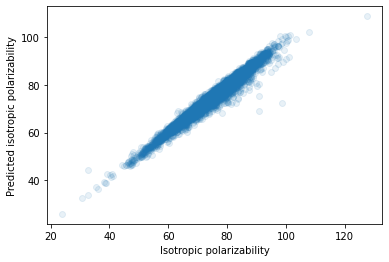

In [60]:
plt.scatter(target, predictions, alpha=0.1)
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')